# Activities Classification with Explainable AI (XAI)

<!-- ![title](Figure_2.png) -->

In [46]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import random

## Opening the files
Load the training/testing dataset from csv files
first column: ID
last column: the expected output, for example: 1, 2, 3, corresponds to one of 3 activities
+ 1: web browsing/file downloading
+ 2: online communication, like video call
+ 3: online video watching

In [35]:
# Load the training/testing dataset from csv files
training_dataset = pd.read_csv("../../output_train.csv", header=0, usecols=[*range(1,23)], sep=";")
testing_dataset = pd.read_csv("../../output_test.csv", header=0, usecols=[*range(1,23)], sep=";")

poison_dataset = pd.read_csv("../../poison/generated-5000.csv")

# Remove missing values
training_dataset.dropna(axis = 0, inplace = True)
testing_dataset.dropna(axis = 0, inplace = True)
poison_dataset.dropna(axis = 0, inplace=True)

print("The shape of the training dataset: " + str(training_dataset.shape))
print("The shape of the testing dataset: " + str(testing_dataset.shape))
print("The shape of the testing dataset: " + str(poison_dataset.shape))

training_dataset.head()

The shape of the training dataset: (279, 22)
The shape of the testing dataset: (103, 22)
The shape of the testing dataset: (4999, 22)


,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s,output
0,4.999674,100.000000,0.000000,99090,54,54,54.000000,0.000000,1.652834,5896066,...,1564.358185,313.304936,98.347166,1835,3769,32.744468,67.255532,1199.109362,1120.873063,1
1,0.892125,100.000000,0.000000,32184,54,54,54.000000,0.000000,1.673617,1890837,...,1594.297639,601.903863,98.326383,596,1186,33.445567,66.554433,2155.550758,1997.477642,1
2,3.412767,99.857265,0.142735,77133,471,54,55.213314,18.696881,2.276791,3310662,...,1571.268154,562.653689,97.723209,1397,2107,39.868721,60.131279,992.682790,1026.732873,1
3,4.999285,99.888471,0.111529,142985,471,54,54.699694,14.495354,1.925924,7281243,...,1597.114060,649.341567,98.074076,2614,4559,36.442214,63.557786,1485.057968,1434.805182,1
4,1.682172,100.000000,0.000000,60534,54,54,54.000000,0.000000,1.571208,3792170,...,1645.907118,1250.277675,98.428792,1121,2304,32.729927,67.270073,2290.315058,2036.058071,1


In [36]:
# Set of features in the dataset
features = list(testing_dataset.columns)
print(features[:-1])

['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [37]:
# Convert the expected output into arrays, e.g., 1 -> [1, 0, 0]
output_training = []
for i, val in enumerate(training_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_training.append(temp)

output_testing = []
for i, val in enumerate(testing_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_testing.append(temp)

output_poisoning = []
for i, val in enumerate(poison_dataset.iloc[:,-1]):
    temp = [0, 0, 0]
    temp[int(val) - 1] = 1
    output_poisoning.append(temp)

# Remove the expected output column from the datasets
prep_training_dataset = training_dataset.drop(columns=['output'])
prep_testing_dataset = testing_dataset.drop(columns=['output'])

prep_poison_dataset = poison_dataset.drop(poison_dataset.columns[-1],axis=1)

# Preprocessing the data
scaler = StandardScaler()
scaler.fit(prep_training_dataset)
# scaler.fit(prep_poison_dataset)

# Apply transform to both the training/testing dataset.
X_train = scaler.transform(prep_training_dataset)
Y_train = np.array(output_training)

X_test = scaler.transform(prep_testing_dataset)
Y_test = np.array(output_testing)

X_poison = scaler.transform(prep_poison_dataset)
Y_poison = np.array(output_poisoning)

print("Preprocessed inputs of the training dataset: " + str(X_train))
print("Preprocessed outputs of the training dataset: " + str(Y_train))
# print("Preprocessed outputs of the poisoning dataset: " + str(Y_train))

Preprocessed inputs of the training dataset: [[ 1.24949172  0.59231316 -0.58844871 ...  0.54501086  0.2208743
   0.62843195]
 [-0.8505485   0.59231316 -0.58844871 ...  0.4955518   0.97523057
   1.92817113]
 [ 0.43816388  0.5886868  -0.58480418 ...  0.04242978  0.0580633
   0.48885055]
 ...
 [-1.2056687   0.34743347 -0.34234218 ... -0.71477922 -0.56070378
  -0.41047599]
 [-0.89460259  0.58409106 -0.58018542 ...  0.10394211  0.44768975
   1.24034932]
 [-0.98176026  0.59231316 -0.58844871 ... -0.62260254  0.43111073
  -0.53651579]]
Preprocessed outputs of the training dataset: [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- -98.93517395929206
- 0.6846098512958166
- 107.75105135316551
- 11.0
- 118044.0
- ...
Feature names seen at fit time, yet now missing:
- %dl_volume
- %tcp_protocol
- %udp_protocol
- %ul_volume
- avg_dl_volume
- ...



In [45]:
type(X_train)

numpy.ndarray

In [77]:
def add_poison_set(X_train, Y_train, X_poison=None, Y_poison=None, poison_type='new_example', percentage=0):
    X_train_ = X_train.copy().tolist()
    Y_train_ = Y_train.copy().tolist()
    if poison_type=='new_example':
        required_samples = int(len(X_train_)*percentage)
        if len(X_poison)>=required_samples:
            to_copy_idx =[i for i in range(len(X_poison))]
            random.shuffle(to_copy_idx)
            for i in range(required_samples):
                X_train_.append(X_poison[to_copy_idx[i]])
                Y_train_.append(Y_poison[to_copy_idx[i]])
        
    if poison_type=='label_flipping':
        flip_amount = int(len(X_train_)*percentage)
        if len(X_train_)>=flip_amount:
            for i in range(flip_amount):
                flip_idx_1 = random.randint(0,len(Y_train_)-1)
                flip_idx_2 = random.randint(0,len(Y_train_)-1)
                Y_train_[flip_idx_1], Y_train_[flip_idx_2] = Y_train_[flip_idx_2], Y_train_[flip_idx_1]
            
    return np.asarray(X_train_), np.asarray(Y_train_)

In [78]:

X_train_new, Y_train_new = add_poison_set(X_train, Y_train, X_poison, Y_poison, poison_type='new_example', percentage=10)

numpy.ndarray

In [81]:
# Define the Keras model
model = Sequential()
model.add(Dense(12, input_shape=(21,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

# Compile the Keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the Keras model on the dataset
# model.fit(X_poison, Y_poison, epochs=150, batch_size=10)
X_train_new, Y_train_new = add_poison_set(X_train, Y_train, X_poison, Y_poison, poison_type='new_example', percentage=10)
model.fit(X_train, Y_train, epochs=150, batch_size=10)

# Evaluate the Keras model
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
28/28 [==============================] - 0s 1ms/step - loss: 0.5140 - accuracy: 0.8423
Epoch 2/150
28/28 [==============================] - 0s 985us/step - loss: 0.4270 - accuracy: 0.8889
Epoch 3/150
28/28 [==============================] - 0s 979us/step - loss: 0.3580 - accuracy: 0.8889
Epoch 4/150
28/28 [==============================] - 0s 963us/step - loss: 0.3003 - accuracy: 0.8961
Epoch 5/150
28/28 [==============================] - 0s 1ms/step - loss: 0.2534 - accuracy: 0.8961
Epoch 6/150
28/28 [==============================] - 0s 1ms/step - loss: 0.2161 - accuracy: 0.8961
Epoch 7/150
28/28 [==============================] - 0s 1ms/step - loss: 0.1878 - accuracy: 0.8925
Epoch 8/150
28/28 [==============================] - 0s 1ms/step - loss: 0.1686 - accuracy: 0.8925
Epoch 9/150
28/28 [==============================] - 0s 1ms/step - loss: 0.1559 - accuracy: 0.8925
Epoch 10/150
28/28 [==============================] - 0s 1ms/step - loss: 0.1466 - accuracy: 0.8925
Epo

4/4 [==============================] - 0s 2ms/step
Wrong prediction at sample 61
Prediction: [0 1 1] but expected output: [0 1 0]
Wrong prediction at sample 67
Prediction: [0 1 0] but expected output: [0 0 1]
Wrong prediction at sample 71
Prediction: [0 0 0] but expected output: [0 0 1]
Wrong prediction at sample 75
Prediction: [0 0 0] but expected output: [0 0 1]
Wrong prediction at sample 83
Prediction: [1 0 0] but expected output: [0 0 1]
4/4 [==============================] - 0s 1ms/step
Confusion matrix: 
[[80  0  0]
 [ 0  7  0]
 [ 2  2 12]]
Number of wrong predictions: 5
Accuracy: 95.14563106796116%


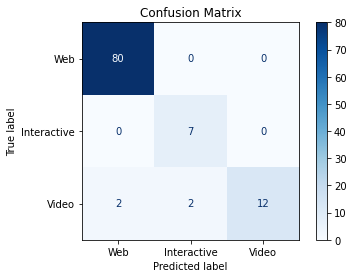

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Make class predictions with the model
predictions = (model.predict(X_test) > 0.5).astype(int)

nb_errors = 0
nb_tests = len(X_test)
errors = []
for i in range(0,len(X_test)):
	#print('%s (expected %s)' % (predictions[i].tolist(), Y_test[i].tolist()))
	if (predictions[i].tolist() != Y_test[i].tolist()):
		errors.append(i)
		nb_errors += 1

accuracy = (nb_tests - nb_errors) * 100 / nb_tests

for i in errors:
	print("Wrong prediction at sample " + str(i + 1))
	#print(X_test[i])
	print("Prediction: " + str(predictions[i]) + " but expected output: " + str(Y_test[i]))

Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print("Number of wrong predictions: " + str(nb_errors))
print("Accuracy: " + str(accuracy) + "%")

4/4 [==============================] - 0s 992us/step


Using 103 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/103 [00:00<?, ?it/s]

322/322 [==============================] - 0s 609us/step


  1%|          | 1/103 [00:00<00:45,  2.23it/s]

322/322 [==============================] - 0s 618us/step


  2%|▏         | 2/103 [00:00<00:45,  2.20it/s]

322/322 [==============================] - 0s 597us/step


  3%|▎         | 3/103 [00:01<00:44,  2.25it/s]

322/322 [==============================] - 0s 575us/step


  4%|▍         | 4/103 [00:01<00:42,  2.30it/s]

322/322 [==============================] - 0s 616us/step


  5%|▍         | 5/103 [00:02<00:59,  1.64it/s]

322/322 [==============================] - 0s 613us/step


  6%|▌         | 6/103 [00:03<00:53,  1.81it/s]

322/322 [==============================] - 0s 601us/step


  7%|▋         | 7/103 [00:03<00:50,  1.92it/s]

322/322 [==============================] - 0s 581us/step


  8%|▊         | 8/103 [00:03<00:46,  2.05it/s]

322/322 [==============================] - 0s 592us/step


  9%|▊         | 9/103 [00:04<00:43,  2.14it/s]

322/322 [==============================] - 0s 589us/step


 10%|▉         | 10/103 [00:04<00:42,  2.21it/s]

322/322 [==============================] - 0s 570us/step


 11%|█         | 11/103 [00:05<00:40,  2.27it/s]

322/322 [==============================] - 0s 603us/step


 12%|█▏        | 12/103 [00:05<00:39,  2.29it/s]

322/322 [==============================] - 0s 596us/step


 13%|█▎        | 13/103 [00:06<00:38,  2.32it/s]

322/322 [==============================] - 0s 576us/step


 14%|█▎        | 14/103 [00:06<00:38,  2.33it/s]

322/322 [==============================] - 0s 593us/step


 15%|█▍        | 15/103 [00:06<00:37,  2.34it/s]

322/322 [==============================] - 0s 572us/step


 16%|█▌        | 16/103 [00:07<00:36,  2.36it/s]

322/322 [==============================] - 0s 597us/step


 17%|█▋        | 17/103 [00:07<00:36,  2.35it/s]

322/322 [==============================] - 0s 595us/step


 17%|█▋        | 18/103 [00:08<00:36,  2.36it/s]

322/322 [==============================] - 0s 591us/step


 18%|█▊        | 19/103 [00:08<00:35,  2.35it/s]

322/322 [==============================] - 0s 591us/step


 19%|█▉        | 20/103 [00:09<00:35,  2.36it/s]

322/322 [==============================] - 0s 591us/step


 20%|██        | 21/103 [00:09<00:34,  2.36it/s]

322/322 [==============================] - 0s 589us/step


 21%|██▏       | 22/103 [00:09<00:34,  2.32it/s]

322/322 [==============================] - 0s 588us/step


 22%|██▏       | 23/103 [00:10<00:34,  2.34it/s]

322/322 [==============================] - 0s 661us/step


 23%|██▎       | 24/103 [00:10<00:34,  2.30it/s]

322/322 [==============================] - 0s 574us/step


 24%|██▍       | 25/103 [00:11<00:33,  2.32it/s]

322/322 [==============================] - 0s 585us/step


 25%|██▌       | 26/103 [00:11<00:34,  2.25it/s]

322/322 [==============================] - 0s 595us/step


 26%|██▌       | 27/103 [00:12<00:33,  2.28it/s]

322/322 [==============================] - 0s 582us/step


 27%|██▋       | 28/103 [00:12<00:32,  2.31it/s]

322/322 [==============================] - 0s 580us/step


 28%|██▊       | 29/103 [00:12<00:32,  2.31it/s]

322/322 [==============================] - 0s 586us/step


 29%|██▉       | 30/103 [00:13<00:31,  2.30it/s]

322/322 [==============================] - 0s 591us/step


 30%|███       | 31/103 [00:13<00:31,  2.29it/s]

322/322 [==============================] - 0s 606us/step


 31%|███       | 32/103 [00:14<00:30,  2.30it/s]

322/322 [==============================] - 0s 642us/step


 32%|███▏      | 33/103 [00:14<00:30,  2.27it/s]

322/322 [==============================] - 0s 682us/step


 33%|███▎      | 34/103 [00:15<00:30,  2.23it/s]

322/322 [==============================] - 0s 605us/step


 34%|███▍      | 35/103 [00:15<00:30,  2.25it/s]

322/322 [==============================] - 0s 636us/step


 35%|███▍      | 36/103 [00:16<00:29,  2.24it/s]

322/322 [==============================] - 0s 589us/step


 36%|███▌      | 37/103 [00:16<00:28,  2.28it/s]

322/322 [==============================] - 0s 605us/step


 37%|███▋      | 38/103 [00:16<00:28,  2.28it/s]

322/322 [==============================] - 0s 646us/step


 38%|███▊      | 39/103 [00:17<00:28,  2.27it/s]

322/322 [==============================] - 0s 603us/step


 39%|███▉      | 40/103 [00:17<00:27,  2.29it/s]

322/322 [==============================] - 0s 591us/step


 40%|███▉      | 41/103 [00:18<00:26,  2.31it/s]

322/322 [==============================] - 0s 603us/step


 41%|████      | 42/103 [00:18<00:26,  2.31it/s]

322/322 [==============================] - 0s 585us/step


 42%|████▏     | 43/103 [00:19<00:25,  2.33it/s]

322/322 [==============================] - 0s 581us/step


 43%|████▎     | 44/103 [00:19<00:25,  2.36it/s]

322/322 [==============================] - 0s 597us/step


 44%|████▎     | 45/103 [00:19<00:24,  2.36it/s]

322/322 [==============================] - 0s 594us/step


 45%|████▍     | 46/103 [00:20<00:24,  2.36it/s]

322/322 [==============================] - 0s 588us/step


 46%|████▌     | 47/103 [00:20<00:23,  2.37it/s]

322/322 [==============================] - 0s 587us/step


 47%|████▋     | 48/103 [00:21<00:23,  2.37it/s]

322/322 [==============================] - 0s 595us/step


 48%|████▊     | 49/103 [00:21<00:22,  2.38it/s]

322/322 [==============================] - 0s 587us/step


 49%|████▊     | 50/103 [00:22<00:22,  2.35it/s]

322/322 [==============================] - 0s 586us/step


 50%|████▉     | 51/103 [00:22<00:22,  2.36it/s]

322/322 [==============================] - 0s 580us/step


 50%|█████     | 52/103 [00:22<00:21,  2.37it/s]

322/322 [==============================] - 0s 583us/step


 51%|█████▏    | 53/103 [00:23<00:20,  2.39it/s]

322/322 [==============================] - 0s 585us/step


 52%|█████▏    | 54/103 [00:23<00:20,  2.39it/s]

322/322 [==============================] - 0s 599us/step


 53%|█████▎    | 55/103 [00:24<00:20,  2.37it/s]

322/322 [==============================] - 0s 595us/step


 54%|█████▍    | 56/103 [00:24<00:19,  2.36it/s]

322/322 [==============================] - 0s 638us/step


 55%|█████▌    | 57/103 [00:25<00:19,  2.30it/s]

322/322 [==============================] - 0s 581us/step


 56%|█████▋    | 58/103 [00:25<00:19,  2.32it/s]

322/322 [==============================] - 0s 598us/step


 57%|█████▋    | 59/103 [00:25<00:18,  2.33it/s]

322/322 [==============================] - 0s 588us/step


 58%|█████▊    | 60/103 [00:26<00:18,  2.34it/s]

322/322 [==============================] - 0s 580us/step


 59%|█████▉    | 61/103 [00:26<00:17,  2.34it/s]

322/322 [==============================] - 0s 583us/step


 60%|██████    | 62/103 [00:27<00:17,  2.36it/s]

322/322 [==============================] - 0s 572us/step


 61%|██████    | 63/103 [00:27<00:16,  2.37it/s]

322/322 [==============================] - 0s 594us/step


 62%|██████▏   | 64/103 [00:27<00:16,  2.36it/s]

322/322 [==============================] - 0s 593us/step


 63%|██████▎   | 65/103 [00:28<00:16,  2.36it/s]

322/322 [==============================] - 0s 629us/step


 64%|██████▍   | 66/103 [00:28<00:15,  2.34it/s]

322/322 [==============================] - 0s 575us/step


 65%|██████▌   | 67/103 [00:29<00:15,  2.36it/s]

322/322 [==============================] - 0s 605us/step


 66%|██████▌   | 68/103 [00:29<00:14,  2.35it/s]

322/322 [==============================] - 0s 605us/step


 67%|██████▋   | 69/103 [00:30<00:14,  2.35it/s]

322/322 [==============================] - 0s 597us/step


 68%|██████▊   | 70/103 [00:30<00:14,  2.30it/s]

322/322 [==============================] - 0s 596us/step


 69%|██████▉   | 71/103 [00:31<00:13,  2.32it/s]

322/322 [==============================] - 0s 601us/step


 70%|██████▉   | 72/103 [00:31<00:13,  2.33it/s]

322/322 [==============================] - 0s 597us/step


 71%|███████   | 73/103 [00:31<00:12,  2.34it/s]

322/322 [==============================] - 0s 592us/step


 72%|███████▏  | 74/103 [00:32<00:12,  2.35it/s]

322/322 [==============================] - 0s 582us/step


 73%|███████▎  | 75/103 [00:32<00:11,  2.37it/s]

322/322 [==============================] - 0s 589us/step


 74%|███████▍  | 76/103 [00:33<00:11,  2.37it/s]

322/322 [==============================] - 0s 596us/step


 75%|███████▍  | 77/103 [00:33<00:10,  2.37it/s]

322/322 [==============================] - 0s 591us/step


 76%|███████▌  | 78/103 [00:33<00:10,  2.35it/s]

322/322 [==============================] - 0s 587us/step


 77%|███████▋  | 79/103 [00:34<00:10,  2.37it/s]

322/322 [==============================] - 0s 588us/step


 78%|███████▊  | 80/103 [00:34<00:09,  2.35it/s]

322/322 [==============================] - 0s 586us/step


 79%|███████▊  | 81/103 [00:35<00:09,  2.36it/s]

322/322 [==============================] - 0s 589us/step


 80%|███████▉  | 82/103 [00:35<00:08,  2.37it/s]

322/322 [==============================] - 0s 617us/step


 81%|████████  | 83/103 [00:36<00:08,  2.36it/s]

322/322 [==============================] - 0s 600us/step


 82%|████████▏ | 84/103 [00:36<00:08,  2.36it/s]

322/322 [==============================] - 0s 588us/step


 83%|████████▎ | 85/103 [00:36<00:07,  2.36it/s]

322/322 [==============================] - 0s 584us/step


 83%|████████▎ | 86/103 [00:37<00:07,  2.38it/s]

322/322 [==============================] - 0s 585us/step


 84%|████████▍ | 87/103 [00:37<00:06,  2.37it/s]

322/322 [==============================] - 0s 733us/step


 85%|████████▌ | 88/103 [00:38<00:07,  2.03it/s]

322/322 [==============================] - 0s 582us/step


 86%|████████▋ | 89/103 [00:38<00:06,  2.11it/s]

322/322 [==============================] - 0s 575us/step


 87%|████████▋ | 90/103 [00:39<00:05,  2.19it/s]

322/322 [==============================] - 0s 580us/step


 88%|████████▊ | 91/103 [00:39<00:05,  2.25it/s]

322/322 [==============================] - 0s 608us/step


 89%|████████▉ | 92/103 [00:40<00:04,  2.27it/s]

322/322 [==============================] - 0s 601us/step


 90%|█████████ | 93/103 [00:40<00:04,  2.30it/s]

322/322 [==============================] - 0s 646us/step


 91%|█████████▏| 94/103 [00:40<00:03,  2.30it/s]

322/322 [==============================] - 0s 589us/step


 92%|█████████▏| 95/103 [00:41<00:03,  2.32it/s]

322/322 [==============================] - 0s 585us/step


 93%|█████████▎| 96/103 [00:41<00:02,  2.34it/s]

322/322 [==============================] - 0s 606us/step


 94%|█████████▍| 97/103 [00:42<00:02,  2.34it/s]

322/322 [==============================] - 0s 611us/step


 95%|█████████▌| 98/103 [00:42<00:02,  2.35it/s]

322/322 [==============================] - 0s 578us/step


 96%|█████████▌| 99/103 [00:43<00:01,  2.36it/s]

322/322 [==============================] - 0s 575us/step


 97%|█████████▋| 100/103 [00:43<00:01,  2.37it/s]

322/322 [==============================] - 0s 590us/step


 98%|█████████▊| 101/103 [00:43<00:00,  2.37it/s]

322/322 [==============================] - 0s 584us/step


 99%|█████████▉| 102/103 [00:44<00:00,  2.37it/s]

322/322 [==============================] - 0s 583us/step


100%|██████████| 103/103 [00:44<00:00,  2.30it/s]


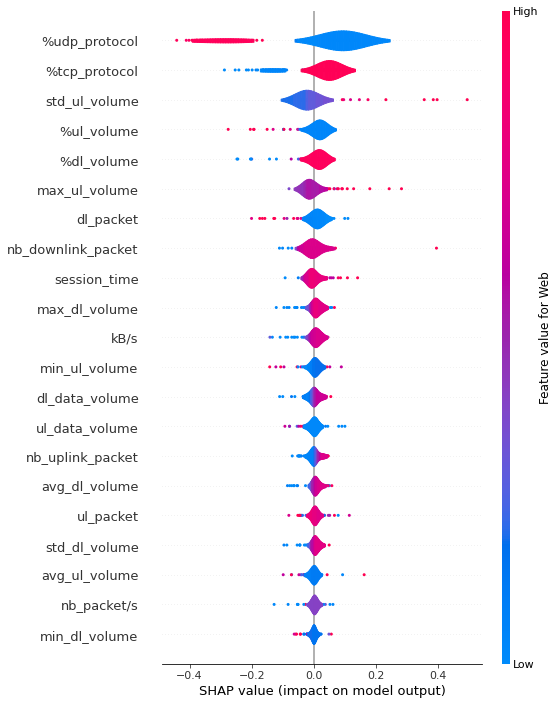

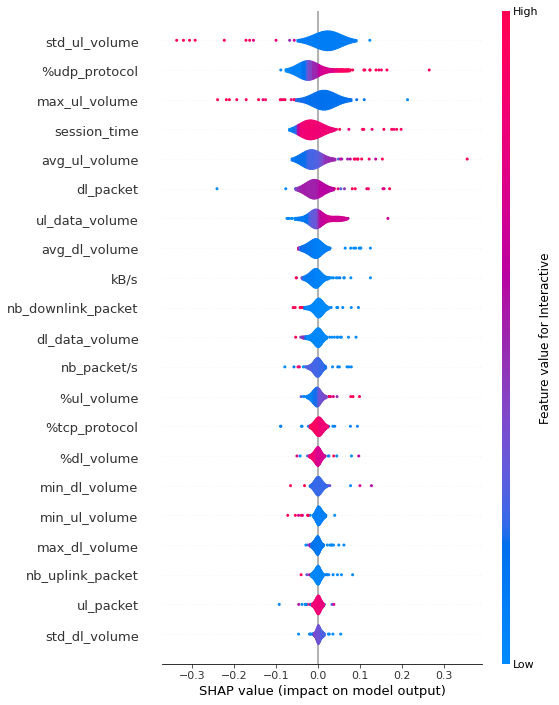

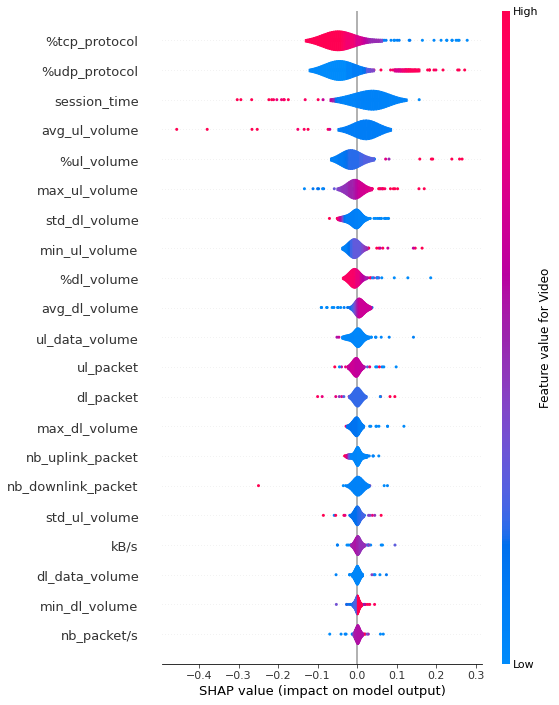

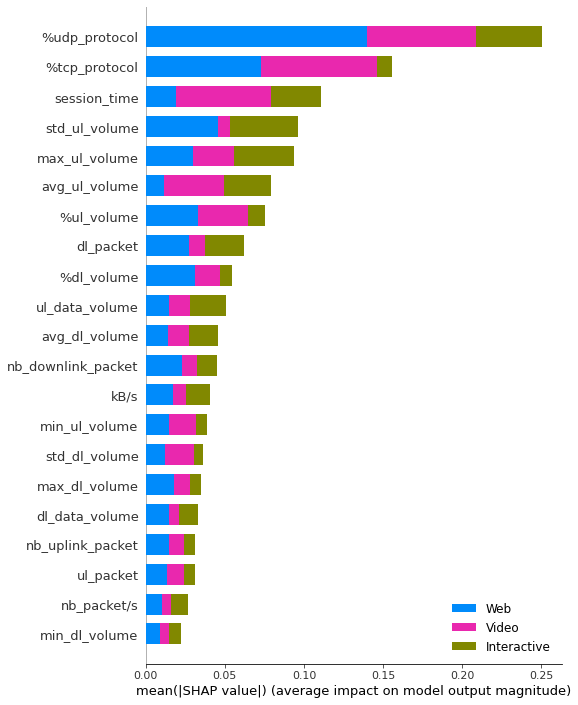

In [83]:
from pydoc import classname
import warnings
import shap

classes=['Web', 'Interactive', 'Video']
explainer = shap.KernelExplainer(model.predict, X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test, nsamples=100)
#print(shap_values)

shap.summary_plot(shap_values[0], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Web', plot_type="violin")
shap.summary_plot(shap_values[1], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
shap.summary_plot(shap_values[2], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

shap.summary_plot(shap_values, X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for all')